# Семинар №11 - Вопросно-ответная система

Сделаем поисковую систему на основе BM25 и BERT, чтобы отфильтровать научные работы по запросу.

## Bert for QA
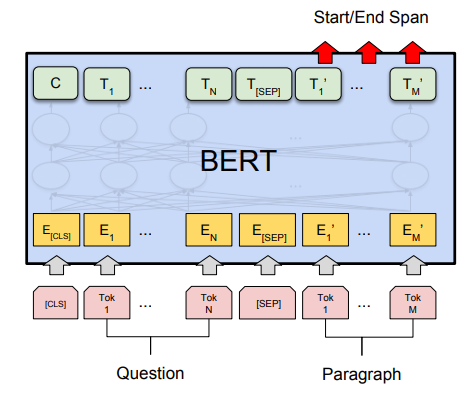

BERT (Bidirectional Encoder Representations from Transformers) - недавняя статья, опубликованная исследователями Google AI Language. Она вызвала ажиотаж в сообществе машинного обучения, представив самые современные результаты в широком спектре задач NLP, включая ответы на вопросы (SQuAD v1.1), вывод на естественном языке (MNLI) и другие.

Ключевым техническим новшеством БЕРТА является применение двунаправленного обучения Transformer, популярной модели внимания, к языковому моделированию. Это контрастирует с предыдущими попытками, в которых рассматривалась последовательность текста либо слева направо, либо комбинированное обучение слева направо и справа налево. Результаты работы показывают, что языковая модель, которая обучается в двух направлениях, может иметь более глубокое представление о языковом контексте и потоке, чем однонаправленные языковые модели. В статье исследователи подробно описывают новую технику под названием Masked LM (MLM), которая позволяет проводить двунаправленное обучение в моделях, в которых ранее это было невозможно.

Question answering (QA) - дисциплина компьютерных наук в области поиска информации и обработки естественного языка (NLP), которая занимается созданием систем, автоматически отвечающих на вопросы, задаваемые людьми на естественном языке.

## BM25
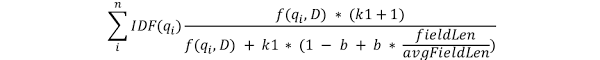

В области поиска информации Okapi BM25 (BM - сокращение от best matching) - это функция ранжирования, используемая поисковыми системами для оценки релевантности документов заданному поисковому запросу. Он основан на системе вероятностного поиска, разработанной в 1970-х и 1980-х годах Стивеном Э. Робертсоном, Карен Сперк Джонс и другими.

Название фактической функции ранжирования - BM25. Более полное название, Okapi BM25, включает название первой системы, которая его использовала, - информационно-поисковой системы Okapi, внедренной в Лондонском городском университете в 1980-х и 1990-х годах. BM25 и его более новые варианты, например BM25F (версия BM25, которая может учитывать структуру документа и текст привязки), представляют собой современные функции поиска, подобные TF-IDF, используемые при поиске документов.

## Install and import packages

In [ ]:
# !pip install rank_bm25 nltk transformers

In [ ]:
import re
import os
import json
from pathlib import Path, PurePath

import requests
from requests.exceptions import HTTPError, ConnectionError

import numpy as np 
import pandas as pd
from tqdm import tqdm
from rank_bm25 import BM25Okapi

import nltk
from nltk.corpus import stopwords
nltk.download("punkt")

import torch
from transformers import BertTokenizer, BertForQuestionAnswering

import warnings
warnings.filterwarnings("ignore")

# Предварительная обработка данных

[Загрузите](https://disk.yandex.ru/d/Z3MfKtbtCwdZkw) полнотекстовые публикации и очистите их.

In [ ]:
merged = pd.read_csv('processed_data_v8_2 2.csv', sep=';')

In [ ]:
merged.head()

## Задача №1

Создайте классную работу, чтобы упростить получение какого-либо поля, такого как аннотация, полный текст, doi и так далее.

In [ ]:
class Paper:
    def __init__(self, item):
        self.paper = item.to_frame().fillna('')
        self.paper.columns = ['Value']
        
    # TODO - реализуйте парсинг таблицы в виде полей класса
    def url(self):
        return None
    
    def text(self):
        return None
    
    def abstract(self):
        return None
    
    def title(self):
        return None
    
    def authors(self, split=False):
        '''
        Get a list of authors
        '''
        return None

## Задача №2

Некоторые функции предварительной обработки для очистки исходных данных. Мы обозначаем текст, удаляем знаки препинания и некоторые специальные символы.

In [ ]:
english_stopwords = list(set(stopwords.words('english')))
SEARCH_DISPLAY_COLUMNS = ['title', 'abstract', 'url', 'authors', 'text']

In [ ]:
def strip_characters(text):
    # TODO удалить символы по типу  \(|\)|:|,|;| и тп
    return text


def clean(text):
    # TODO проведите очистку текста и преобразование к нижнему регистру
    return text


def tokenize(text):
    words = nltk.word_tokenize(text)
    return list(
        set([word for word in words 
             if len(word) > 1
             and not word in english_stopwords
             and not (word.isnumeric() and len(word) is not 4)
             and (not word.isnumeric() or word.isalpha())])
    )


def preprocess(text):
    t = clean(text)
    tokens = tokenize(t)
    
    return tokens

# Поисковая система BM25
Определите класс для построения индекса и поиска по строкам.

In [ ]:
class SearchResults:
    def __init__(self,
                 data: pd.DataFrame,
                 columns = None):
        self.results = data
        if columns:
            self.results = self.results[columns]
            
    def __getitem__(self, item):
        return Paper(self.results.loc[item])
    
    def __len__(self):
        return len(self.results)
    
    def set_ans(self, ans):
        col_name = self.results.columns.tolist()
        col_name.insert(2, 'Answer')
        self.results = self.results.reindex(columns=col_name)
        self.results['Answer'] = ans

In [ ]:
class WordTokenIndex:
    def __init__(self, 
                 corpus: pd.DataFrame, 
                 columns=SEARCH_DISPLAY_COLUMNS):
        self.corpus = corpus

        raw_search_str = self.corpus.abstract.fillna('') + ' ' + self.corpus.title.fillna('')
        self.index = raw_search_str.apply(preprocess).to_frame()
        self.index.columns = ['terms']
        self.index.index = self.corpus.index
        self.columns = columns
    
    def search(self, search_string):
        search_terms = preprocess(search_string)
        # получить индексы, включающие строку search_string
        result_index = self.index.terms.apply(lambda terms: any(i in terms for i in search_terms))
        # получить найденные papers
        results = self.corpus[result_index].copy().reset_index().rename(columns={'index':'paper'})
        
        return SearchResults(results, self.columns + ['paper'])

In [ ]:
class RankBM25Index(WordTokenIndex):
    def __init__(self, corpus: pd.DataFrame, columns=SEARCH_DISPLAY_COLUMNS):
        super().__init__(corpus, columns)
        self.bm25 = BM25Okapi(self.index.terms.tolist())
        
    def search(self, search_string, n=4):
        search_terms = preprocess(search_string)
        doc_scores = self.bm25.get_scores(search_terms)
        
        ind = np.argsort(doc_scores)[::-1][:n]
        results = self.corpus.iloc[ind][self.columns]
        results['Score'] = doc_scores[ind]
        results = results[results.Score > 0]
        
        return SearchResults(results.reset_index(), self.columns + ['Score'])

# Bert furtuer pre-train and fine
Используйте реализацию transformers bert и загрузите предварительно обученную модель "bert-base-uncased". Мы используем все статьи в качестве корпуса для дальнейшего предварительного обучения bert задаче языковой модели. После дальнейшей предварительной подготовки мы используем набор данных SQuAD-2.0 для точной настройки модели bert. Наконец, мы сохраняем обученную модель, которая называется "output_squad".

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForQuestionAnswering.from_pretrained('bert-base-uncased')

# QA function
Создайте функцию контроля качества, которая получает вопрос и фрагмент текста, передает их в модель bert и выводит возможный ответ в тексте. Если модель выдает неверный ответ, функция выдаст "Нет ответа".

## Постройте пайплайн поиска и покажите результаты

### Задача №3
Мы показываем выходные данные модели в таблицах и заключаем их в "【】", чтобы представить ответ в статье.

In [ ]:
max_question_len = 100

def getAnswer(question, text):
    # TODO расширьте реализацию поиска по всем токенам документа, а не 512 
    
    input_ids = tokenizer.encode(question, text, max_length=512)
    # mask text sequence  # 102 - SEP между question и text
    token_type_ids = [0 if i <= input_ids.index(102) else 1 for i in range(len(input_ids))]
    
    model_out = model(torch.tensor([input_ids]), token_type_ids=torch.tensor([token_type_ids]))
    start_scores, end_scores = model_out['start_logits'], model_out['end_logits']
    
    all_tokens = tokenizer.convert_ids_to_tokens(input_ids)
    
    # выделить  часть за начало ответа и его конец
    start_scores = start_scores[0, input_ids.index(102):]  # bs = 1
    end_scores = end_scores[0, input_ids.index(102):]  # bs = 1
    
    if torch.argmax(start_scores).item() >= torch.argmax(end_scores).item():
        return "No Answer"

    # выделить токены до ответа + [ начало контекста ответа
    all_tokens = all_tokens[: input_ids.index(102) + torch.argmax(start_scores)] + ["【"] + all_tokens[input_ids.index(102) + torch.argmax(start_scores):]
    # выделить токены конца ответа контекста ] + токены после ответа
    all_tokens = all_tokens[: input_ids.index(102) + torch.argmax(end_scores) + 1] + ["】"] + all_tokens[input_ids.index(102) + torch.argmax(end_scores) + 1:]
    
    # найти начало и конец ответа
    start_span = max(input_ids.index(102) + torch.argmax(start_scores) - 5, input_ids.index(102))
    end_span = min(input_ids.index(102) + torch.argmax(end_scores) + 6, len(all_tokens) + 1)

    answer = tokenizer.convert_tokens_to_string(all_tokens[start_span:end_span])
    answer = answer.replace("[SEP]", "")
    return answer

In [ ]:
query = 'What is it omphalitis'
text = merged.iloc[0].text

### Задача №4
Соберем весь процесс поиска в одной функции.

In [ ]:
def searchAndGetAnswer(question, top_bm=50, top_k=10):
    assert top_bm > top_k and top_bm > 1 and top_k > 1, 'set top_bm > top_k > 1'
    # TODO получите предварительный результат поиска с BM25
    results = []

    ans_list = []
    ans_index = []
    for i in range(len(results)):
        text = results[i].text()
        # TODO получите результаты поиска по топу из BM25
        ans = None 
        if ans == "No Answer":
            continue
        
        ans_list.append(ans)
        ans_index.append(i)
        print("{}/{}".format(len(ans_index), top_k))
        if len(ans_index) >= top_k:
            break
            
    results.results = results.results.loc[ans_index, :].reset_index()

    # Append to metadata
    results.set_ans(ans_list)
    
    # Change the order
    cols = ['title', 'abstract', 'Answer', 'Score', 'url', 'authors']
    res = results.results.loc[:,cols]
    return res

In [ ]:
bm25_index = RankBM25Index(merged)

### Q1: *Real-time tracking of whole genomes and a mechanism for coordinating the rapid dissemination of that information to inform the development of diagnostics and therapeutics and to track variations of the virus over time.*

In [ ]:
p = "Real-time tracking of whole genomes and a mechanism for coordinating the rapid dissemination of that information to inform the development of diagnostics and therapeutics and to track variations of the virus over time."
res = searchAndGetAnswer(p)
res

In [ ]:
res['Answer']

### Q2: *Access to geographic and temporal diverse sample sets to understand geographic distribution and genomic differences, and determine whether there is more than one strain in circulation. Multi-lateral agreements such as the Nagoya Protocol could be leveraged.*

In [ ]:
p = "Access to geographic and temporal diverse sample sets to understand geographic distribution and genomic differences, and determine whether there is more than one strain in circulation. Multi-lateral agreements such as the Nagoya Protocol could be leveraged."
res = searchAndGetAnswer(p)
res

### Q3: *Evidence that livestock could be infected (e.g., field surveillance, genetic sequencing, receptor binding) and serve as a reservoir after the epidemic appears to be over.*
* Evidence of whether farmers are infected, and whether farmers could have played a role in the origin.
* Surveillance of mixed wildlife- livestock farms for SARS-CoV-2 and other coronaviruses in Southeast Asia.
* Experimental infections to test host range for this pathogen.

In [ ]:
p = '''
Evidence that livestock could be infected (e.g., field surveillance, genetic sequencing, receptor binding) and serve as a reservoir after the epidemic appears to be over.
Evidence of whether farmers are infected, and whether farmers could have played a role in the origin.
Surveillance of mixed wildlife- livestock farms for SARS-CoV-2 and other coronaviruses in Southeast Asia.
Experimental infections to test host range for this pathogen.
'''
res = searchAndGetAnswer(p)
res

### Q4: *Animal host(s) and any evidence of continued spill-over to humans*

In [ ]:
p = '''
Animal host(s) and any evidence of continued spill-over to humans
'''
res = searchAndGetAnswer(p)
res

### Q5: *Socioeconomic and behavioral risk factors for this spill-over*

In [ ]:
p = '''
Socioeconomic and behavioral risk factors for this spill-over
'''
res = searchAndGetAnswer(p)
res

### Q6: *Sustainable risk reduction strategies*

In [ ]:
p = '''
Sustainable risk reduction strategies
'''
res = searchAndGetAnswer(p)
res